# Anotação aos professores e avaliadores:
Para o funcionamento adequado do código, é necessário que a variável `AZURE_ACCOUNT_KEY` na célula abaixo seja preenchida com a **secret key** enviada junto ao PDF do projeto, ou que essa chave seja configurada como variável de ambiente `export AZURE_ACCOUNT_KEY="secret_key_aqui"`.
Essa medida foi adotada por questões de segurança, uma vez que o repositório é público.
Agradecemos desde já pela compreensão e colaboração.

In [18]:
# Coloque aqui sua chave de conta do Azure
AZURE_ACCOUNT_KEY = ""

# Imports

In [16]:
import os
from io import BytesIO, StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from azure.storage.blob import BlobServiceClient
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


# Configuration

In [17]:
AZURE_ACCOUNT_KEY = os.environ.get("AZURE_ACCOUNT_KEY", AZURE_ACCOUNT_KEY)
if not AZURE_ACCOUNT_KEY:
    raise ValueError("A chave da conta do Azure não foi definida. Por favor, defina a variável AZURE_ACCOUNT_KEY.")

AZURE_CONNECTION_STRING = f"DefaultEndpointsProtocol=https;AccountName=totsvisiodb;AccountKey={AZURE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"

# Inicializa o cliente do Blob
blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)

# Dataframe Definition:

In [19]:
CONTAINER_NAME = "csvs-tratados-gpt"
BLOB_NAME = "processed/2025-08-24_043101/mrr.csv"

blob_client = blob_service_client.get_blob_client(container=CONTAINER_NAME, blob=BLOB_NAME)
downloaded_blob = blob_client.download_blob().readall()
mrr_df = pd.read_csv(BytesIO(downloaded_blob), encoding="utf-8-sig", sep=";")

In [20]:
mrr_df.head()

,CLIENTE,MRR_12M
0,T03360,485.245250
1,T01872,287.070309
2,T01899,628.717296
3,T01670,207.503636
4,T02817,890.027855


# Clustering

In [21]:
# 1. Seleciona as features numéricas relevantes
features = [
    'MRR_12M'
]
X = mrr_df[features].copy()

In [22]:
# Trata NaNs (preencher com média)
X = X.fillna(X.mean())

In [23]:
# Padroniza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Aplica KMeans com 3 clusters (inicial)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [25]:
# Adiciona os clusters ao DataFrame
mrr_df['cluster'] = clusters

# Visualiza os primeiros registros com clusters
mrr_df.head()

,CLIENTE,MRR_12M,cluster
0,T03360,485.245250,0
1,T01872,287.070309,0
2,T01899,628.717296,0
3,T01670,207.503636,0
4,T02817,890.027855,0


Visualizamos quantidade de clientes por cluster:

In [26]:
mrr_df.cluster.value_counts()

cluster
0    6866
2     436
1       7
Name: count, dtype: int64

In [27]:
# Validar com Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {sil_score:.3f}')

Silhouette Score: 0.812


Visualizamos a distribuição dos clientes por cluster

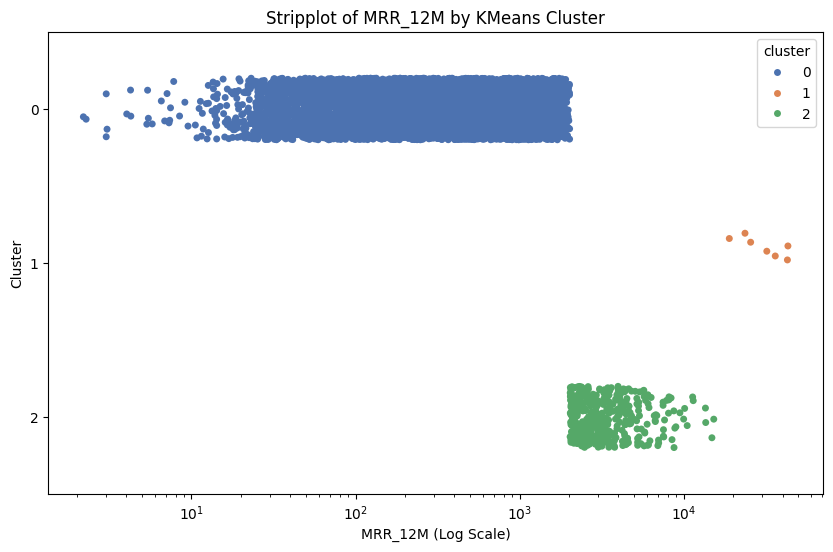

In [30]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=mrr_df, x='MRR_12M', y='cluster', hue='cluster', palette='deep', jitter=0.2, size=5, orient='h')
plt.xscale('log')
plt.title('Stripplot of MRR_12M by KMeans Cluster')
plt.xlabel('MRR_12M (Log Scale)')
plt.ylabel('Cluster')
plt.show()

A célula abaixo pode estar em formato raw para evitar risco de inserção no container novamente.

In [33]:
# Essa célula pode estar em formato raw para evitar risco de inserção no container repetidamente

# 1. Convertemos o DataFrame para CSV em memória
csv_buffer = StringIO()
mrr_df.to_csv(csv_buffer, index=False, encoding="utf-8")

# 2. Criamos um client para o novo container
container_name = "clusters"
blob_name = "mrr_clusters.csv"

# Cria o container se ainda não existir
#blob_service_client.create_container(container_name) # Comentamos para não ocasionar erro ao tentar criar um container já existente

# 3. Criamos client do blob no novo container
blob_client = blob_service_client.get_blob_client(
    container=container_name,
    blob=blob_name
)

# 4. Upload do CSV
blob_client.upload_blob(csv_buffer.getvalue(), overwrite=True)

print("Arquivo exportado para o container 'clusters' com sucesso!")


Arquivo exportado para o container 'clusters' com sucesso!
